IMPORT DEPENDENCIES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Set seeds for reproducibility

In [5]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

setting Constants

Directory Path

In [6]:
IMAGE_SIZE = 180
BATCH_SIZE = 32
# Dataset Path
base_dir = 'E:/Jupyter notebook/3_plant_diseased/training/Corn_diseased/corn'

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)

Found 3852 files belonging to 4 classes.


In [8]:
class_names = dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight']

In [9]:
class_len = len(class_names)
class_len

4

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 180, 180, 3)
[2 0 2 3 1 0 2 2 0 3 1 3 3 1 0 2 1 2 1 1 2 3 0 3 0 3 1 2 2 0 3 2]


# DATA VISUALIZATION

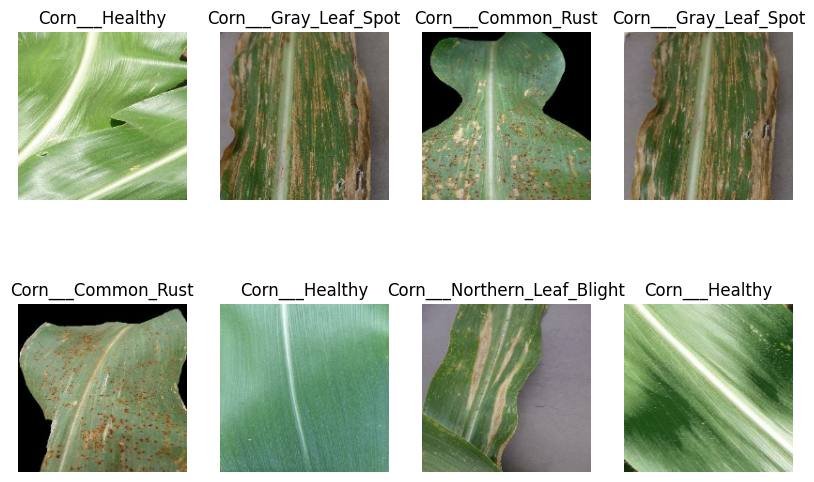

In [11]:
plt.figure(figsize=(10,10))
from numpy import uint16
for image_batch, label_batch in dataset.take(1):
  for i in range(8):
      plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

# TRAIN TEST SPLIT
50 % TRAINING

30 % VALIDATION

10 % TEST

In [12]:
'''
import splitfolders

# Path to the input data folder
input_folder = 'F:/Jupyter notebook/5_plant_Diseased/training/Corn_diseased/corn'

# Path to the output folder where split data will be saved
output_folder = 'F:/Jupyter notebook/5_plant_Diseased/training/Corn_diseased/splited-corn'

# Define the desired split ratios
split_ratios = (0.5, 0.3, 0.2)  # train, valid, test

# Use split_folders to perform the split
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=split_ratios, group_prefix=None)
'''

"\nimport splitfolders\n\n# Path to the input data folder\ninput_folder = 'F:/Jupyter notebook/5_plant_Diseased/training/Corn_diseased/corn'\n\n# Path to the output folder where split data will be saved\noutput_folder = 'F:/Jupyter notebook/5_plant_Diseased/training/Corn_diseased/splited-corn'\n\n# Define the desired split ratios\nsplit_ratios = (0.5, 0.3, 0.2)  # train, valid, test\n\n# Use split_folders to perform the split\nsplitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=split_ratios, group_prefix=None)\n"

AUGMENT TRAIN

In [13]:
'''
import os
import cv2
from PIL import Image
import imgaug.augmenters as iaa
import numpy as np
from tqdm import tqdm

# Define your dataset directory
dataset_dir = 'F:/Jupyter notebook/5_Plant_Diseased/training/Corn_diseased/splited-corn/train'
output_dir = 'F:/Jupyter notebook/5_Plant_Diseased/training/Corn_diseased/splited-corn/augmentedtrain'
# Define augmentation methods
augmentations = [
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Affine(rotate=(-20, 20)),  # random rotations
    iaa.Multiply((0.8, 1.2)),  # random brightness
    iaa.GaussianBlur(sigma=(0.0, 1.0)),  # gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))  # additive gaussian noise
]

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through each class directory
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)
    
    # Loop through each image in the class directory
    for filename in tqdm(os.listdir(class_dir), desc=f'Augmenting {class_name}'):
        img_path = os.path.join(class_dir, filename)
        
        # Load image using OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (imgaug requires RGB images)
        
        # Apply augmentations
        for aug in augmentations:
            augmented_img = aug.augment_image(img)
            
            # Convert augmented image back to BGR for OpenCV and save
            augmented_img_bgr = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)
            output_path = os.path.join(output_class_dir, f'{os.path.splitext(filename)[0]}_{augmentations.index(aug)}.jpg')
            cv2.imwrite(output_path, augmented_img_bgr)

print('Augmentation completed!')
'''

"\nimport os\nimport cv2\nfrom PIL import Image\nimport imgaug.augmenters as iaa\nimport numpy as np\nfrom tqdm import tqdm\n\n# Define your dataset directory\ndataset_dir = 'F:/Jupyter notebook/5_Plant_Diseased/training/Corn_diseased/splited-corn/train'\noutput_dir = 'F:/Jupyter notebook/5_Plant_Diseased/training/Corn_diseased/splited-corn/augmentedtrain'\n# Define augmentation methods\naugmentations = [\n    iaa.Fliplr(0.5),  # horizontal flips\n    iaa.Affine(rotate=(-20, 20)),  # random rotations\n    iaa.Multiply((0.8, 1.2)),  # random brightness\n    iaa.GaussianBlur(sigma=(0.0, 1.0)),  # gaussian blur\n    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))  # additive gaussian noise\n]\n\n# Ensure output directory exists\nos.makedirs(output_dir, exist_ok=True)\n\n# Loop through each class directory\nfor class_name in os.listdir(dataset_dir):\n    class_dir = os.path.join(dataset_dir, class_name)\n    output_class_dir = os.path.join(output_dir, class_name)\n    os.makedirs(output_cla

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
datagen = ImageDataGenerator(
    rescale=1./255
)

In [15]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    'E:/Jupyter notebook/3_Plant_Diseased/training/Corn_diseased/splited-corn/augmentedtrain',
    shuffle = True,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9625 images belonging to 4 classes.


In [16]:
# Valid generator
valid_generator = datagen.flow_from_directory(
    'E:/Jupyter notebook/3_plant_Diseased/training/Corn_diseased/splited-corn/val',
    shuffle = True,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1153 images belonging to 4 classes.


In [17]:
# Test Generator
test_ds = tf.keras.utils.image_dataset_from_directory(
  'E:/Jupyter notebook/3_plant_Diseased/training/Corn_diseased/splited-corn/test',
  label_mode ='categorical',
  shuffle = False,
  image_size = (IMAGE_SIZE, IMAGE_SIZE),
  batch_size = BATCH_SIZE
)

Found 774 files belonging to 4 classes.


Shuffle the test dataset

In [18]:
test_ds_shuffled = test_ds.shuffle(buffer_size=1000)

In [19]:
# MODEL ARCHITECTURE

In [20]:
# Define input layer
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Convolutional layers
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Dropout(0.25)(x)

# Flatten layer
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer for multi-class classification
outputs = layers.Dense(class_len, activation='softmax')(x)  
# Create the model using Functional API
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Define optimizer with custom learning rate
learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      52,429,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,802,180 (201.42 MB)

 Trainable params: 52,802,180 (201.42 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
EPOCHS = 25
history = model.fit(
  train_generator,
  validation_data = valid_generator,
  epochs = EPOCHS
)

Epoch 1/25


C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.6311 - loss: 0.8636 - val_accuracy: 0.8699 - val_loss: 0.4040
Epoch 2/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.8338 - loss: 0.3751 - val_accuracy: 0.8552 - val_loss: 0.3894
Epoch 3/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.8529 - loss: 0.3186 - val_accuracy: 0.8994 - val_loss: 0.2480
Epoch 4/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.8742 - loss: 0.2885 - val_accuracy: 0.8942 - val_loss: 0.2451
Epoch 5/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.8861 - loss: 0.2629 - val_accuracy: 0.9141 - val_loss: 0.2019
Epoch 6/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.8950 - loss: 0.2446 - val_accuracy: 0.9141 - val_loss: 0.2127
Epoch 7/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 750s 2s/step - accuracy: 0.9051 - loss: 0.2272 - val_accuracy: 0.9245 - val_loss: 0.1741
Epoch 8/25
301/301 ━━━━━━━━━━━━━━━━━━━━ 738s 2s/step - accuracy: 0.9063 - loss: 0.2175 - val_accuracy: 0.902

EVALUATE TEST

In [22]:
test_loss, test_accuracy = model.evaluate(test_ds_shuffled)                                                         
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step - accuracy: 0.8882 - loss: 75.9901
Test Loss: 53.5101
Test Accuracy: 0.9173


In [23]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

In [24]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Loss')
plt.subplots_adjust(wspace=0.3)
plt.show()

# MAP classes into ARABIC STRUCTURE

PROVIDE THE CURE

In [25]:
class_info = {
    0 : {'name': 'الصدي الشائع في الدرة', 'description': ''' الصدي الشائع في الدرة هو مرض فطري يصيب نبات الذرة. هذا المرض ينتج عن الفطر Ustilago maydis وينتشر بشكل واسع في مناطق زراعة الذرة.

أعراض الإصابة:
- ظهور بثرات أو عقد لحمية على أوراق النبات والسيقان والأكواز.
- تشوه وتضخم الأجزاء المصابة.
- إنتاج بودرة سوداء داخل البثرات (وهي أبواغ الفطر).

الأضرار:
- انخفاض إنتاجية المحصول بشكل ملحوظ.
- تدهور جودة الحبوب المنتجة.

طرق العلاج والوقاية:
- استخدام أصناف مقاومة للمرض عند الزراعة.
- إتباع دورة زراعية سليمة وتخفيف كثافة الزراعة.
- إزالة وحرق النباتات المصابة لتقليل مصادر العدوى.
- المكافحة الكيميائية باستخدام مبيدات فطرية مناسبة عند الضرورة.

بالتطبيق الصحيح لهذه التدابير يمكن الحد من انتشار هذا المرض وتقليل الخسائر الناتجة عنه في محصول الذرة.'''},
    1: {'name': 'بقع رماديه في الدره', 'description': '''  التبقع الرمادي هو مرض فطري يصيب نبات الذرة، وينتج عن الفطر Cercospora zeae-maydis. ينتشر هذا المرض في المناطق الرطبة والدافئة حيث يتم زراعة الذرة.

أعراض الإصابة:

ظهور بقع رمادية مستطيلة أو دائرية على الأوراق.
تكون حواف البقع ذات لون أغمق من الوسط.
تجفيف الأوراق المصابة تدريجياً مما يؤدي إلى تساقطها.
الأضرار:

تقليل قدرة النبات على التمثيل الضوئي بسبب فقدان الأوراق.
انخفاض إنتاجية المحصول.
تدهور جودة الحبوب المنتجة.
طرق العلاج والوقاية:

استخدام أصناف مقاومة للمرض عند الزراعة.
تحسين التهوية بين النباتات من خلال تخفيف كثافة الزراعة.
إزالة بقايا المحاصيل المصابة من الحقل بعد الحصاد.
المكافحة الكيميائية باستخدام مبيدات فطرية مناسبة عند الضرورة.
بالتطبيق الصحيح لهذه التدابير يمكن الحد من انتشار هذا المرض وتقليل الخسائر الناتجة عنه في محصول الذرة.'''},
    2: {'name': 'دره', 'description': ' صحيه'},
    3: {'name': 'اللفحة الشمالية في الدرة', 'description': '''  اللفحة الشمالية في الذرة هي مرض فطري ينتج عن الفطر Exserohilum turcicum. ينتشر هذا المرض بشكل واسع في المناطق التي تتميز بالطقس الرطب والدافئ.

أعراض الإصابة:

ظهور بقع بنية طولية على الأوراق، تكون أحياناً محددة بحواف صفراء.
انتشار البقع بشكل تدريجي على الأوراق مما يؤدي إلى ذبولها.
ظهور تقرحات على السيقان وأجزاء أخرى من النبات في الحالات الشديدة.
الأضرار:

تقليل القدرة على التمثيل الضوئي بسبب فقدان الأوراق.
انخفاض إنتاجية المحصول بشكل ملحوظ.
تدهور جودة الحبوب المنتجة.
طرق العلاج والوقاية:

زراعة أصناف مقاومة للمرض.
إتباع دورة زراعية سليمة لتقليل مصادر العدوى.
تحسين التهوية بين النباتات من خلال تخفيف كثافة الزراعة.
المكافحة الكيميائية باستخدام مبيدات فطرية مناسبة عند الضرورة.
بالتطبيق الصحيح لهذه التدابير يمكن الحد من انتشار هذا المرض وتقليل الخسائر الناتجة عنه في محصول الذرة.'''},

}

# Building a Predictive System

In [26]:
# Load and preprocess the image using Pillow
from PIL import Image
def load_and_preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    # Convert the image to a NumPy array
    image_array = np.array(image)
    return image_array

# Prediction function
def predict(model, image_path):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)
    # Resize the image
    image = tf.image.resize(image, (180, 180))
    # Normalize the image
    image = image / 255.0
    # Perform prediction using the model
    predicted_scores = model.predict(np.expand_dims(image, axis=0))  # Expand dimensions to match the input shape
    predicted_class = np.argmax(predicted_scores)
    confidence = np.max(predicted_scores) * 100  # Convert to percentage
    return predicted_class, confidence

In [27]:
class_names = {v: k for k, v in train_generator.class_indices.items()}
class_names

{0: 'Corn___Common_Rust',
 1: 'Corn___Gray_Leaf_Spot',
 2: 'Corn___Healthy',
 3: 'Corn___Northern_Leaf_Blight'}

In [28]:
image_path = 'E:/Jupyter notebook/3_plant_Diseased/training/Corn_diseased/splited-corn/test/Corn___Northern_Leaf_Blight/image (56).JPG'
predicted_class_index, confidence = predict(model, image_path)

# Get the Arabic name and description for the predicted class
arabic_name = class_info[predicted_class_index]['name']
description = class_info[predicted_class_index]['description']

# Print the result
print(f"Predicted Class: {predicted_class_index}")
print(f"Arabic Name: {arabic_name}")
print(f"Description: {description}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: 3
Arabic Name: اللفحة الشمالية في الدرة
Description:   اللفحة الشمالية في الذرة هي مرض فطري ينتج عن الفطر Exserohilum turcicum. ينتشر هذا المرض بشكل واسع في المناطق التي تتميز بالطقس الرطب والدافئ.

أعراض الإصابة:

ظهور بقع بنية طولية على الأوراق، تكون أحياناً محددة بحواف صفراء.
انتشار البقع بشكل تدريجي على الأوراق مما يؤدي إلى ذبولها.
ظهور تقرحات على السيقان وأجزاء أخرى من النبات في الحالات الشديدة.
الأضرار:

تقليل القدرة على التمثيل الضوئي بسبب فقدان الأوراق.
انخفاض إنتاجية المحصول بشكل ملحوظ.
تدهور جودة الحبوب المنتجة.
طرق العلاج والوقاية:

زراعة أصناف مقاومة للمرض.
إتباع دورة زراعية سليمة لتقليل مصادر العدوى.
تحسين التهوية بين النباتات من خلال تخفيف كثافة الزراعة.
المكافحة الكيميائية باستخدام مبيدات فطرية مناسبة عند الضرورة.
بالتطبيق الصحيح لهذه التدابير يمكن الحد من انتشار هذا المرض وتقليل الخسائر الناتجة عنه في محصول الذرة.
Confidence: 99.24%


# Example Usage

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Actual Class Index: 0, Actual Class: Corn___Common_Rust
Predicted Class Index: 0, Predicted Confidence: 99.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Actual Class Index: 0, Actual Class: Corn___Common_Rust
Predicted Class Index: 0, Predicted Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Actual Class Index: 0, Actual Class: Corn___Common_Rust
Predicted Class Index: 0, Predicted Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Actual Class Index: 0, Actual Class: Corn___Common_Rust
Predicted Class Index: 0, Predicted Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Actual Class Index: 0, Actual Class: Corn___Common_Rust
Predicted Class Index: 0, Predicted Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Actual Class Index: 0, Actual Class: Corn___Common_Rust
Predicted Class Index: 0, Predicted Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Actual Class Index: 0, Actual Class: Corn___Common_Rust
Pre

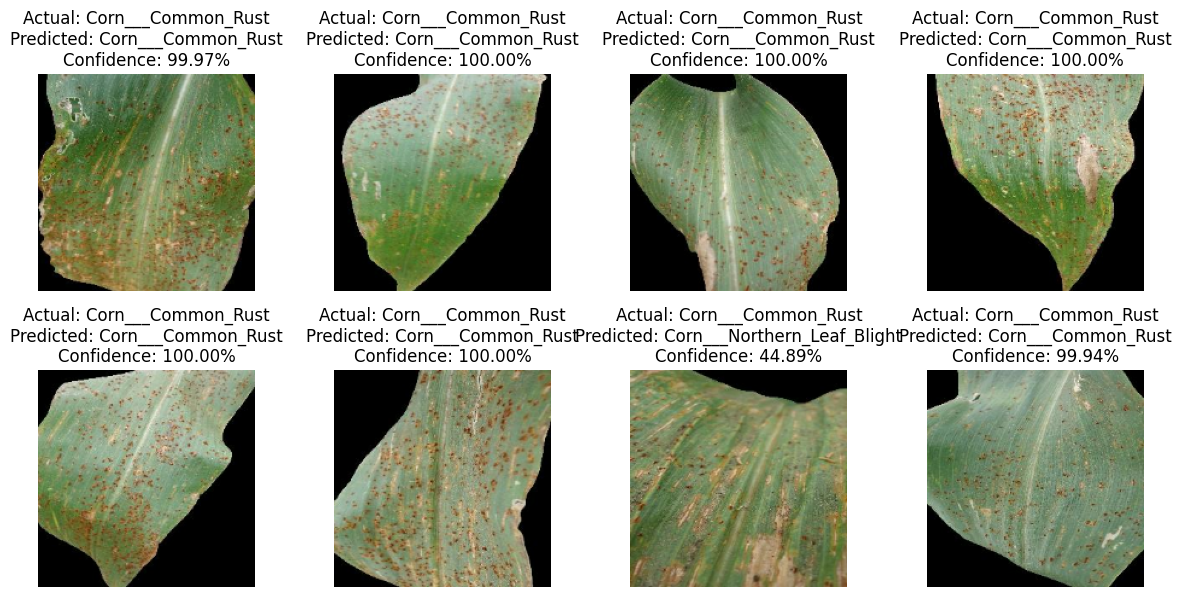

In [29]:
# Set up the figure to display images
import tempfile
plt.figure(figsize=(12, 12))

# Iterate over the first batch of images and labels from the shuffled test dataset
for images, labels in test_ds_shuffled.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        
        # Convert image tensor to numpy array with uint8 data type for visualization
        image_np = images[i].numpy().astype('uint8')
        
        # Save the image as a temporary file
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_file:
            image_pil = Image.fromarray(image_np)
            image_pil.save(temp_file.name)
        
        # Display the image
        plt.imshow(image_np)
        
        # Perform prediction using the defined `predict` function
        predicted_class, confidence = predict(model, temp_file.name)
        
        # Extract the actual class index from `labels` tensor
        labels_np = labels[i].numpy()  # Convert label tensor to numpy array
        if isinstance(labels_np, np.ndarray) and labels_np.size > 1:
            actual_class_index = np.argmax(labels_np)  # For one-hot encoded labels
        else:
            actual_class_index = int(labels_np)  # For scalar labels
        
        # Verify that the actual_class_index is within valid range
        if 0 <= actual_class_index < len(class_names):
            actual_class = class_names[actual_class_index]
        else:
            actual_class = f"Unknown Class (Index: {actual_class_index})"
        
        # Print label info and predicted class for debugging
        print(f"Actual Class Index: {actual_class_index}, Actual Class: {actual_class}")
        print(f"Predicted Class Index: {predicted_class}, Predicted Confidence: {confidence:.2f}%")
        
        # Check if predicted_class is within the range of class_names
        if 0 <= predicted_class < len(class_names):
            predicted_label = class_names[predicted_class]
        else:
            predicted_label = f"Unknown Class (Index: {predicted_class})"
        
        # Set the title with formatted text showing actual label, predicted label, and confidence
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}%")
        
        # Turn off axis for cleaner visualization
        plt.axis("off")

plt.tight_layout()
plt.show()

# SAVE

Save and try to load

In [32]:
model.save('potatomodel.keras')
model.save('potatomodel.h5')

In [ ]:
# Load the model without the optimizer state
#new_model = tf.keras.models.load_model('corn_diseasedmodel.keras', compile=False)

# Print the model summary
#new_model.summary()